# Imports and Definitions

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import os
import shutil
import csv
from datetime import datetime

SEED = 999
np.random.seed(SEED)

In [ ]:
# Plotting the graph for the solution

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
def create_csv(results, results_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
# Function for creating validation folder and allow experiment replication

def shuffle_validation_weighted(base_dir, split = 0.2, reset = "reset", filepath = None):
    import os
    import shutil
    import numpy as np
    import pickle

    ######################################
    # USAGE
    # reset = "reset" to create validation
    # reset = "restore" to start again with initial training
    # reset = "dump" to create a file of validation in the current state and reproduce
    # reset = "rest_dump" to restore from dump file
    # (filepath must be specified with the path of the file)

    # verbose = 1/2 gives insight on execution
    # split determine number of images in validation.

    # Create validation_set weighted on number of occurrences in training_set
    train_dir = os.path.join(base_dir, 'training')
    valid_dir = os.path.join(base_dir, 'validation')

    if reset == "reset":
        # First identify training and validation dir
        if not os.path.exists(valid_dir):
            os.makedirs(valid_dir)

        # Count elements in each dir in training
        class_and_card = {name: len(os.listdir(os.path.join(train_dir, name))) for name in os.listdir(train_dir) if
                          os.path.join(train_dir, name)}

        print(class_and_card)
        # Get images per class wrt total images
        class_and_card_validation = {name: int(class_and_card[name] * split) for name in class_and_card}

        print(class_and_card_validation)
        # Select images to move
        for key, item in class_and_card_validation.items():
            source_dir = os.path.join(train_dir, key)
            images = os.listdir(source_dir)
            np.random.shuffle(images)
            target_dir = os.path.join(valid_dir, key)
            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            for i in range(item):
                shutil.move(os.path.join(source_dir, images[i]), target_dir)
    elif reset == "restore":
        # Restore initial state
        # For each class, move images to train_dir in respective folders
        if not os.path.exists(valid_dir):
            print("No valid folder")
            return
        classes = [name for name in os.listdir(valid_dir)]
        for class_name in classes:
            source_dir = os.path.join(valid_dir, class_name)
            images = os.listdir(source_dir)
            target_dir = os.path.join(train_dir, class_name)
            for img in images:
                shutil.move(os.path.join(source_dir, img), target_dir)

    elif reset == "dump":
        # Dump valid images into a text file array
        # Useful for restoring
        if not os.path.exists(valid_dir):
            print("No valid folder")
            return
        classes = [name for name in os.listdir(valid_dir)]
        all_images = {i: None for i in classes}
        for class_name in classes:
            source_dir = os.path.join(valid_dir, class_name)
            images = os.listdir(source_dir)
            all_images[class_name] = images
        images_file = open(os.path.join(base_dir, "dump"), "wb")
        pickle.dump(all_images, images_file)
        images_file.close()

    elif reset == "rest_dump" and os.path.exists(filepath):
        img_file = open(filepath, "rb")
        all_images = pickle.load(img_file)
        img_file.close()
        shuffle_validation_weighted(base_dir, reset="restore", filepath=None)
        for key, item in all_images.items():
            source_dir = os.path.join(train_dir, key)
            images = item
            np.random.shuffle(images)
            target_dir = os.path.join(valid_dir, key)
            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            for img in images:
                shutil.move(os.path.join(source_dir, img), target_dir)

# Hyperparameters and Callbacks

In [ ]:
# We executed a scoped GridSearch on the following parameters
# Dense Layers -> [1, 2] (tested parameters)
# Neurons Number -> [256, 512, 1024, 2048]
# Image Size -> [224, 299, 352, 512] (same for heigth and width)
# Batch Size -> [8, 16, 32]
# Valid Percentage -> [0.2]
# Starting Learning Rate -> [1e-3, 1e-4, 1e-5]
# LR1 values -> [0, 0.0001, 0.001]
# LR2 values -> [0, 0.0005, 0.0001, 0.001]
# Below we have the best results

nb_train_samples = 4492
nb_val_samples = 1122
img_w, img_h = 512, 512
num_classes = 3

batch_size = 16
valid_split_perc = 0.2
epochs_fine = 100
learning_rate = 1e-4

# dropout_rate = 0.3
dense_neurons = 512
train_after_layer = len(keras.applications.VGG19(weights='imagenet',
                                         include_top=False,
                                         input_shape=(img_w, img_h, 3)).layers) - 1
l1 = 0
l2 = 0.0005

In [ ]:
save_fld = '/content/drive/My Drive/Shit_datas'

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 6)

# Dataset Loading and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import os
import tensorflow as tf
import numpy as np

cwd = os.getcwd()
cwd = os.path.join(cwd, 'MaskDataset')
if os.path.exists(cwd):
  shutil.rmtree(cwd)
!unzip '/content/drive/My Drive/MaskDataset'

Output streaming troncato alle ultime 5000 righe.
  inflating: MaskDataset/training/0/12637.jpg  
  inflating: MaskDataset/training/0/12638.jpg  
  inflating: MaskDataset/training/0/12639.jpg  
  inflating: MaskDataset/training/0/12644.jpg  
  inflating: MaskDataset/training/0/12650.jpg  
  inflating: MaskDataset/training/0/12652.jpg  
  inflating: MaskDataset/training/0/12655.jpg  
  inflating: MaskDataset/training/0/12658.jpg  
  inflating: MaskDataset/training/0/12663.jpg  
  inflating: MaskDataset/training/0/12666.jpg  
  inflating: MaskDataset/training/0/12667.jpg  
  inflating: MaskDataset/training/0/12668.jpg  
  inflating: MaskDataset/training/0/12672.jpg  
  inflating: MaskDataset/training/0/12678.jpg  
  inflating: MaskDataset/training/0/12681.jpg  
  inflating: MaskDataset/training/0/12684.jpg  
  inflating: MaskDataset/training/0/12689.jpg  
  inflating: MaskDataset/training/0/12700.jpg  
  inflating: MaskDataset/training/0/12703.jpg  
  inflating: MaskDataset/training/0/12

In [ ]:
shuffle_validation_weighted(cwd, split=valid_split_perc, reset="reset")
shuffle_validation_weighted(cwd, split=valid_split_perc, reset="dump")

{'1': 1897, '0': 1900, '2': 1817}
{'1': 379, '0': 380, '2': 363}


In [ ]:
# Data creation with ImageDataGenerator and flow_from_directory
# We didn't use flow_from_dataframe since it also augument validation dataset with validation percentage

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode="nearest",
                                   preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_directory(os.path.join(cwd, 'training'),
                                                    target_size=(img_w, img_h),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    seed = SEED)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

val_generator = val_datagen.flow_from_directory(os.path.join(cwd, 'validation'),
                                                target_size=(img_w, img_h),
                                                batch_size=batch_size,
                                                shuffle=False,
                                                class_mode='categorical',
                                                seed = SEED)

Found 4492 images belonging to 3 classes.
Found 1122 images belonging to 3 classes.


# Model Definition

In [ ]:
# Show model

base_model = keras.applications.VGG19(weights='imagenet',
                                         include_top=False,
                                         input_shape=(img_w, img_h, 3))

for layer in base_model.layers[:train_after_layer]:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.SeparableConv2D):
        layer.trainable = False

base_model.summary()
print('TOTAL NUMBER OF LAYERS: ' + str(len(base_model.layers)))

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [ ]:
model = keras.models.Sequential()

model.add(base_model)
# We choose GlobalAveragePooling2D for efficiency and because it provided better performance
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(dense_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

In [ ]:
# This function allows to create weights for dataset unbalance
# This is an option for giving different weight to class loss

from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

We tried, for the following network, training in different phases.
Each phase is described in detail in the sections.
Starting weights were taken from imagenet.

Combinations tried:
1.  Fully Locked CNN, 16 layers unlocked, Fully Unlocked
2.  Fully Unlocked Network
3.  Fully Locked CNN, Fully Unlocked
4.  Fully Locked CNN, 16, 11, Fully Unlocked

Below is used the best combination

# Training (1 - Locked CNN)

Epoch 1/100
280/280 [==============================] - 322s 1s/step - loss: 1.6844 - accuracy: 0.4707 - val_loss: 1.0588 - val_accuracy: 0.6491
Epoch 2/100
280/280 [==============================] - 320s 1s/step - loss: 1.2235 - accuracy: 0.5715 - val_loss: 0.9497 - val_accuracy: 0.6973
Epoch 3/100
280/280 [==============================] - 322s 1s/step - loss: 1.0986 - accuracy: 0.6048 - val_loss: 0.8991 - val_accuracy: 0.7196
Epoch 4/100
280/280 [==============================] - 320s 1s/step - loss: 1.0147 - accuracy: 0.6358 - val_loss: 0.8829 - val_accuracy: 0.7232
Epoch 5/100
280/280 [==============================] - 317s 1s/step - loss: 0.9807 - accuracy: 0.6591 - val_loss: 0.8673 - val_accuracy: 0.7250
Epoch 6/100
280/280 [==============================] - 316s 1s/step - loss: 0.9446 - accuracy: 0.6761 - val_loss: 0.8441 - val_accuracy: 0.7446
Epoch 7/100
280/280 [==============================] - 310s 1s/step - loss: 0.9385 - accuracy: 0.6709 - val_loss: 0.8134 - val_accuracy:

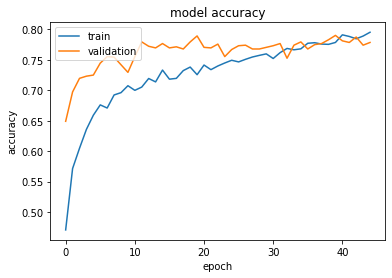

In [ ]:
# RBLROnPlateau monitor val loss and decrease LR
cb_checkpointer = ModelCheckpoint(filepath = save_fld + '/vgg19.hdf5', monitor = 'val_loss', save_best_only = True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor=0.7, patience = 4, min_lr=5e-5)

hist = model.fit(train_generator,
                 steps_per_epoch=nb_train_samples // batch_size,
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=nb_val_samples // batch_size,
                 callbacks=[cb_checkpointer, cb_early_stopper, lr_callback],
                 verbose = 1, class_weight={i: class_weights[i] for i in range(3)})

plot_hist(hist)

# SCORED MAX RESULT -> 314s 1s/step - loss: 0.6513 - accuracy: 0.7846 - val_loss: 0.6770 - val_accuracy: 0.7875

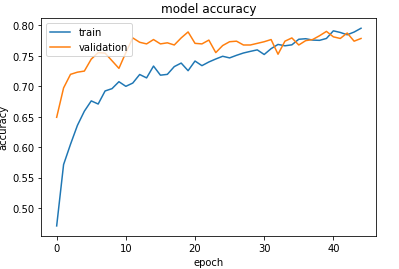

# Training (2 - Partially Unlocked)

Network is partially unfreezed until layer 16

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 16, 16, 512)       20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 20,288,579
Trainable params: 9,703,427
Non-trainable params: 10,585,152
_________________________________________________________________
Epoch 1/100
280/280 [==============================] - 337s 1s/step - loss: 0.8187 - accuracy: 0.6897 

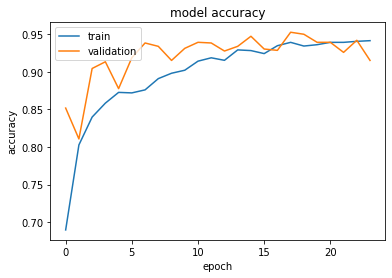

In [ ]:
model.load_weights(save_fld + "/vgg19.hdf5")

learning_rate = 5e-4

for layer in base_model.layers[16:]:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.SeparableConv2D):
        layer.trainable = True

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

cb_checkpointer = ModelCheckpoint(filepath = save_fld + '/vgg19partial.hdf5', monitor = 'val_loss', save_best_only = True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor=0.6, patience = 2, min_lr=7e-5)

hist = model.fit(train_generator,
                 steps_per_epoch=nb_train_samples // batch_size,
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=nb_val_samples // batch_size,
                 callbacks=[cb_checkpointer, cb_early_stopper, lr_callback],
                 verbose = 1, class_weight={i: class_weights[i] for i in range(3)})

plot_hist(hist)

# BEST RESULT (where the accuracy used for the test set is reached) -> 347s 1s/step - loss: 0.2144 - accuracy: 0.9392 - val_loss: 0.1865 - val_accuracy: 0.9527

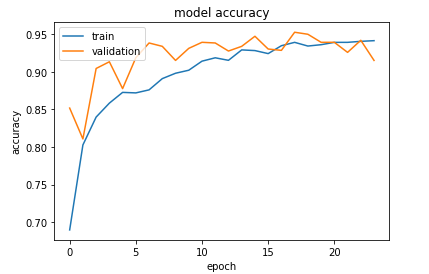

In [ ]:
model.load_weights(save_fld + "/vgg19partial.hdf5")

test_dir = os.path.join(cwd, 'test')

test_data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

test_gen = test_data_gen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict(test_gen, verbose=1)

results = {}

images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
for layer in base_model.layers:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.SeparableConv2D):
        layer.trainable = True
create_csv(results, cwd)

Found 450 images belonging to 1 classes.
450/450 [==============================] - 18s 40ms/step


# Training (3 - Fully Unlocked)

Network fully unlocked



In [ ]:
learning_rate = 1e-4

for layer in base_model.layers:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.SeparableConv2D):
        layer.trainable = False
for layer in base_model.layers[16:]:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.SeparableConv2D):
        layer.trainable = True

model.load_weights(save_fld + "/vgg19partial.hdf5")

for layer in base_model.layers:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.SeparableConv2D):
        layer.trainable = True

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

cb_checkpointer = ModelCheckpoint(filepath = save_fld + '/vgg19FULL.hdf5', monitor = 'val_accuracy', save_best_only = True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor=0.5, patience = 2, min_lr=1e-6)

hist = model.fit(train_generator,
                 steps_per_epoch=nb_train_samples // batch_size,
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=nb_val_samples // batch_size,
                 callbacks=[cb_checkpointer, cb_early_stopper, lr_callback],
                 verbose = 1, class_weight={i: class_weights[i] for i in range(3)})

plot_hist(hist)

In [ ]:
model.load_weights(save_fld + "/vgg19FULL.hdf5")

test_dir = os.path.join(cwd, 'test')

test_data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

test_gen = test_data_gen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict(test_gen, verbose=1)

results = {}

images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, cwd)

# Testing and Creating CSV

In [ ]:
model.load_weights(save_fld + "/vgg19partial.hdf5")

test_dir = os.path.join(cwd, 'test')

test_data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

test_gen = test_data_gen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict(test_gen, verbose=1)

results = {}

images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, cwd)